<a href="https://colab.research.google.com/github/buketugurlu/BUSI/blob/main/BUSI_unetpp_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Train size: 452, Validation size: 97, Test size: 98


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 284MB/s]


Epoch 1/20, Train Loss: 1.1808, Validation Loss: 1.1109
Epoch 2/20, Train Loss: 0.8725, Validation Loss: 0.9397
Epoch 3/20, Train Loss: 0.7024, Validation Loss: 0.7983
Epoch 4/20, Train Loss: 0.6115, Validation Loss: 0.7580
Epoch 5/20, Train Loss: 0.5677, Validation Loss: 0.7123
Epoch 6/20, Train Loss: 0.5147, Validation Loss: 0.6895
Epoch 7/20, Train Loss: 0.4404, Validation Loss: 0.6426
Epoch 8/20, Train Loss: 0.4263, Validation Loss: 0.6301
Epoch 9/20, Train Loss: 0.3796, Validation Loss: 0.6091
Epoch 10/20, Train Loss: 0.3432, Validation Loss: 0.5876
Epoch 11/20, Train Loss: 0.3173, Validation Loss: 0.5566
Epoch 12/20, Train Loss: 0.2888, Validation Loss: 0.5332
Epoch 13/20, Train Loss: 0.2750, Validation Loss: 0.5030
Epoch 14/20, Train Loss: 0.2521, Validation Loss: 0.4882
Epoch 15/20, Train Loss: 0.2360, Validation Loss: 0.4960
Epoch 16/20, Train Loss: 0.2220, Validation Loss: 0.4998
Epoch 17/20, Train Loss: 0.2018, Validation Loss: 0.4805
Epoch 18/20, Train Loss: 0.1923, Validat

<ipython-input-2-a82fc7782354>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/Dataset_BUSI_with_GT/best_unetpp_

Evaluation Metrics:
  Accuracy: 0.9605
  Precision: 0.7394
  Recall: 0.7878
  F1 Score: 0.7628
  Dice Score: 0.7628
  IoU: 0.6166


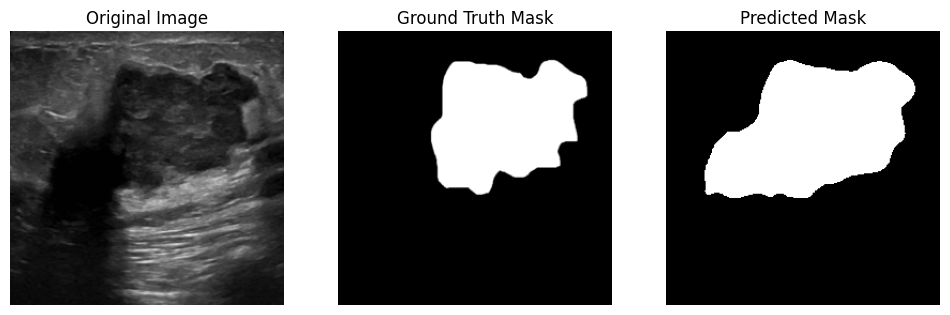

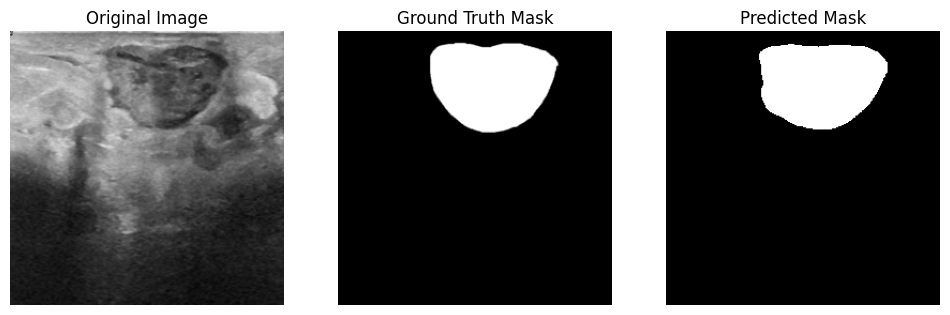

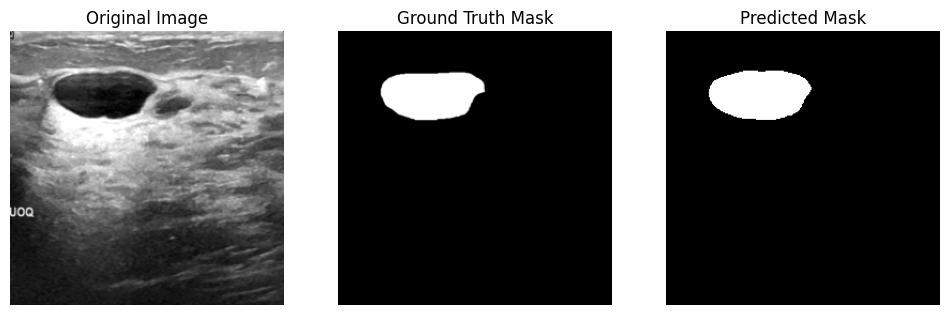

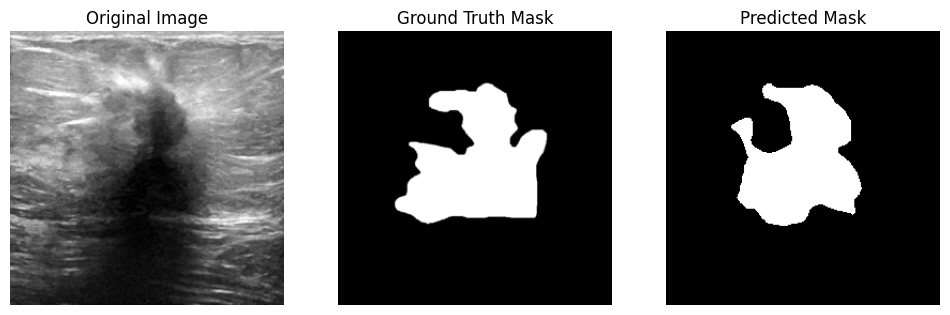

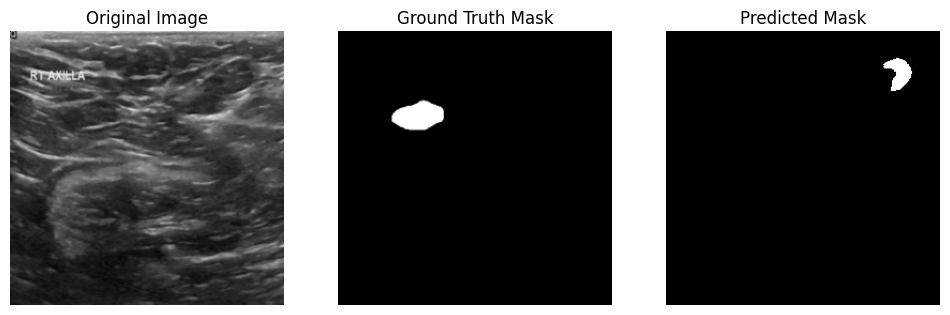

In [2]:
# Install necessary libraries
!pip install segmentation-models-pytorch torch torchvision scikit-learn

# Import libraries
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return image, mask

# Load and split the dataset
image_paths, mask_paths = [], []
for cls in ['benign', 'malignant']:
    image_dir = os.path.join(base_dir, cls)
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "_mask" not in filename:
            image_paths.append(os.path.join(image_dir, filename))
            mask_paths.append(os.path.join(image_dir, filename.replace(".png", "_mask.png")))

# Split into train, validation, and test sets
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

print(f"Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}")

# Define image and mask transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = BreastUltrasoundDataset(train_images, train_masks, transform_image, transform_mask)
val_dataset = BreastUltrasoundDataset(val_images, val_masks, transform_image, transform_mask)
test_dataset = BreastUltrasoundDataset(test_images, test_masks, transform_image, transform_mask)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define UNet++ model
model = smp.UnetPlusPlus(
    encoder_name="resnet34",        # Encoder type
    encoder_weights="imagenet",    # Pretrained weights
    in_channels=3,                 # RGB channels
    classes=1                      # Binary segmentation
).cuda()

# Loss functions and optimizer
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = torch.nn.BCEWithLogitsLoss()

def combined_loss(predictions, targets):
    return dice_loss(predictions, targets) + bce_loss(predictions, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = model(images)
        loss = combined_loss(predictions, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            predictions = model(images)
            loss = combined_loss(predictions, masks)
            val_loss += loss.item()

    # Print epoch statistics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/best_unetpp_model.pth')

# Load the best model
model.load_state_dict(torch.load('/content/drive/My Drive/Dataset_BUSI_with_GT/best_unetpp_model.pth'))

# Evaluate model
def evaluate_model(dataset, model, num_samples=100):
    model.eval()
    all_preds = []
    all_masks = []
    for i in range(min(num_samples, len(dataset))):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()
        mask = mask.cpu().numpy()
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        all_preds.append(prediction_binary.flatten())
        all_masks.append(mask.flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    dice_score = (2.0 * np.logical_and(y_true, y_pred).sum()) / (y_true.sum() + y_pred.sum() + 1e-6)
    iou = np.logical_and(y_true, y_pred).sum() / (np.logical_or(y_true, y_pred).sum() + 1e-6)

    print("Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Dice Score: {dice_score:.4f}")
    print(f"  IoU: {iou:.4f}")

# Visualize predictions
def visualize_predictions(dataset, model, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image_input = image.unsqueeze(0).cuda()
        with torch.no_grad():
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Evaluate and visualize
evaluate_model(test_dataset, model)
visualize_predictions(test_dataset, model, num_samples=5)
